In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
me2011 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2011_smd_hourly.xls")
me2011 = pd.read_excel(me2011, 'ME')
me2012 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2012_smd_hourly.xls")
me2012 = pd.read_excel(me2012, 'ME')
me2013 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2013_smd_hourly.xls")
me2013 = pd.read_excel(me2013, 'ME')
me2014 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2014_smd_hourly.xls")
me2014 = pd.read_excel(me2014, 'ME')
me2015 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2015_smd_hourly.xls")
me2015 = pd.read_excel(me2015, 'ME')
me2016 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2016_smd_hourly.xls")
me2016 = pd.read_excel(me2016, 'ME')

In [3]:
me2017 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2017_smd_hourly.xlsx", 'ME')
me2018 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2018_smd_hourly.xlsx", 'ME')
me2019 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2019_smd_hourly.xlsx", 'ME')
me2020 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2020_smd_hourly.xlsx", 'ME')
me2021 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2021_smd_hourly.xlsx", 'ME')
me2022 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2022_smd_hourly.xlsx", 'ME')

In [4]:
me2022

,Date,Hr_End,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point
0,2022-01-01,1,867.0,1152.722,32.86,32.35,0.23,0.28,26.59,25.95,0.0,0.64,35,35
1,2022-01-01,2,978.2,1116.946,33.00,32.31,0.28,0.41,26.50,25.87,0.0,0.63,35,35
2,2022-01-01,3,923.3,1093.610,31.52,30.85,0.00,0.67,28.11,27.50,0.0,0.61,35,35
3,2022-01-01,4,906.2,1085.773,30.30,29.69,0.00,0.61,25.67,25.13,0.0,0.54,35,35
4,2022-01-01,5,921.8,1099.982,31.53,30.86,0.00,0.67,29.99,29.27,0.0,0.72,35,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2022-01-31,20,1633.2,1846.799,222.87,226.40,0.00,-3.53,295.56,295.80,0.0,-0.24,16,6
740,2022-01-31,21,1522.4,1777.463,199.97,202.82,0.00,-2.85,262.68,264.21,0.0,-1.53,12,4
741,2022-01-31,22,1325.4,1699.196,180.35,183.42,0.00,-3.07,250.05,251.93,0.0,-1.88,13,5
742,2022-01-31,23,1177.7,1555.524,177.46,179.93,0.00,-2.47,188.78,190.96,0.0,-2.18,10,4


In [5]:
val2011 = me2011['DEMAND']
val2012 = me2012['DEMAND']
val2013 = me2013['DEMAND']
val2014 = me2014['DEMAND']
val2015 = me2015['DEMAND']
val2016 = me2016['RT_Demand']
val2017 = me2017['RT_Demand']
val2018 = me2018['RT_Demand']
val2019 = me2019['RT_Demand']
val2020 = me2020['RT_Demand']
val2021 = me2021['RT_Demand']
val2022 = me2022['RT_Demand']

In [6]:
values = [val2011, val2012, val2013, val2014, val2015, val2016, val2017, val2018, val2019, val2020, val2021, val2022]
values_df = pd.concat(values, axis=0, ignore_index=False)
values_df = values_df.reset_index()
period = len(values_df)

In [7]:
rng = pd.date_range('2011-01-01', periods=period, freq='1H')
date_df = pd.DataFrame({ 'ds': rng})
date_df = date_df.reset_index()

In [8]:
frames = [date_df, values_df]
me_load = pd.concat(frames, axis=1, ignore_index=False)
me_load = me_load.rename(columns={me_load.columns[1]: 'ds', me_load.columns[3]: 'y'})
frames2 = [me_load['ds'], me_load['y']]
me_load = pd.concat(frames2, axis=1, ignore_index=False)
me_load

,ds,y
0,2011-01-01 00:00:00,1048.000
1,2011-01-01 01:00:00,1000.000
2,2011-01-01 02:00:00,964.000
3,2011-01-01 03:00:00,954.000
4,2011-01-01 04:00:00,960.000
...,...,...
97171,2022-01-31 19:00:00,1846.799
97172,2022-01-31 20:00:00,1777.463
97173,2022-01-31 21:00:00,1699.196
97174,2022-01-31 22:00:00,1555.524


In [9]:
model = Prophet(
        changepoint_prior_scale=0.5, 
        seasonality_mode='multiplicative', 
        interval_width=0.95, 
    )
model.add_country_holidays(country_name='US')

In [10]:
model.fit(me_load)

In [11]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('me_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

# Forecasting

In [12]:
with open('me_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [14]:
future_pd = m.make_future_dataframe(
        periods=365, 
        freq='D',
        include_history=False
    )
    
# make predictions
forecast_pd = m.predict(future_pd)

In [15]:
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
360,2023-01-27 23:00:00,1322.425794,864.403930,1755.671181
361,2023-01-28 23:00:00,1262.239972,775.394663,1711.611134
362,2023-01-29 23:00:00,1321.558768,835.506995,1785.749796
363,2023-01-30 23:00:00,1370.202006,872.582556,1857.667637
364,2023-01-31 23:00:00,1359.091715,856.225202,1817.746611


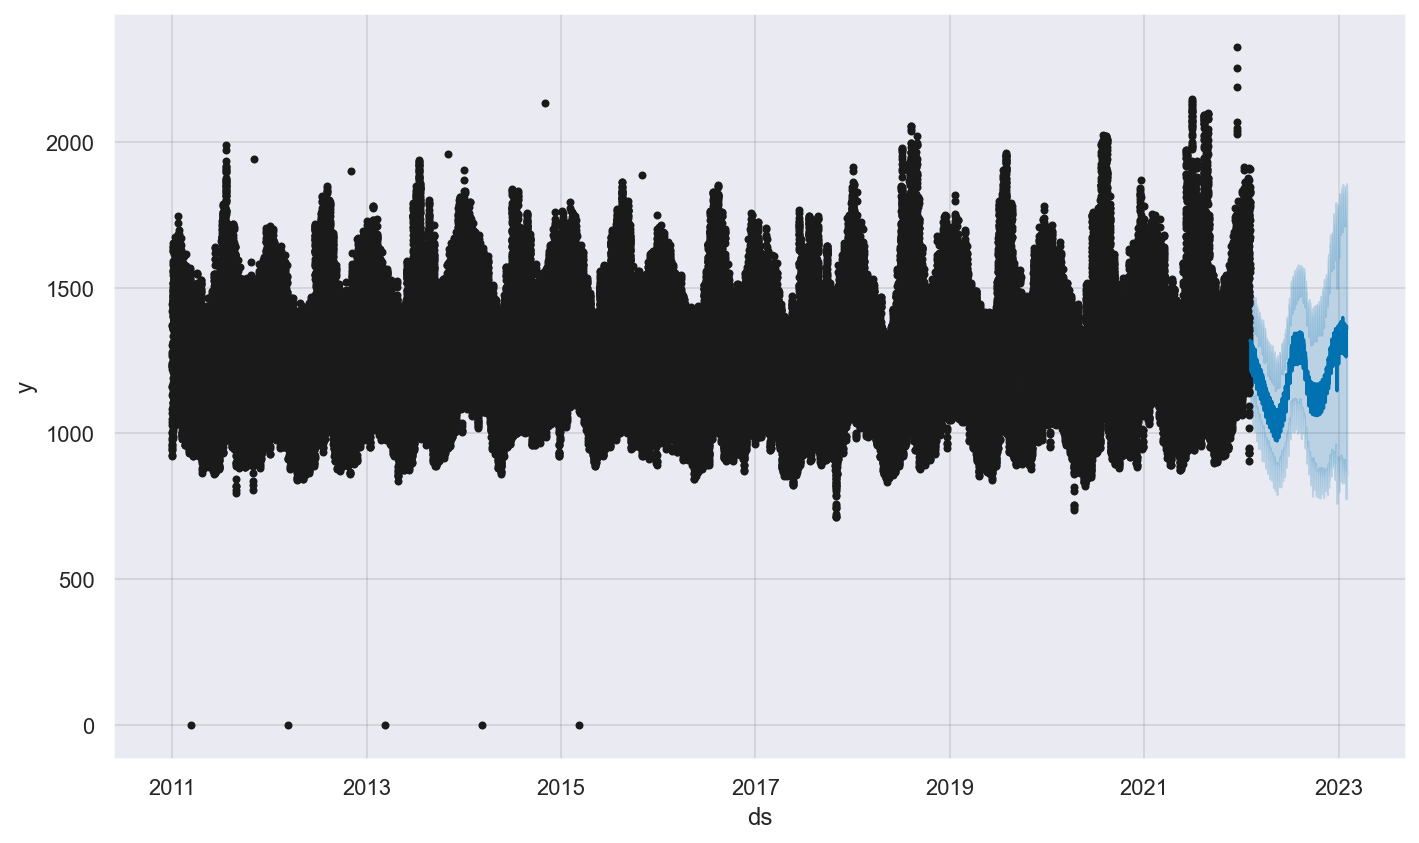

In [16]:
fig1 = model.plot(forecast_pd)

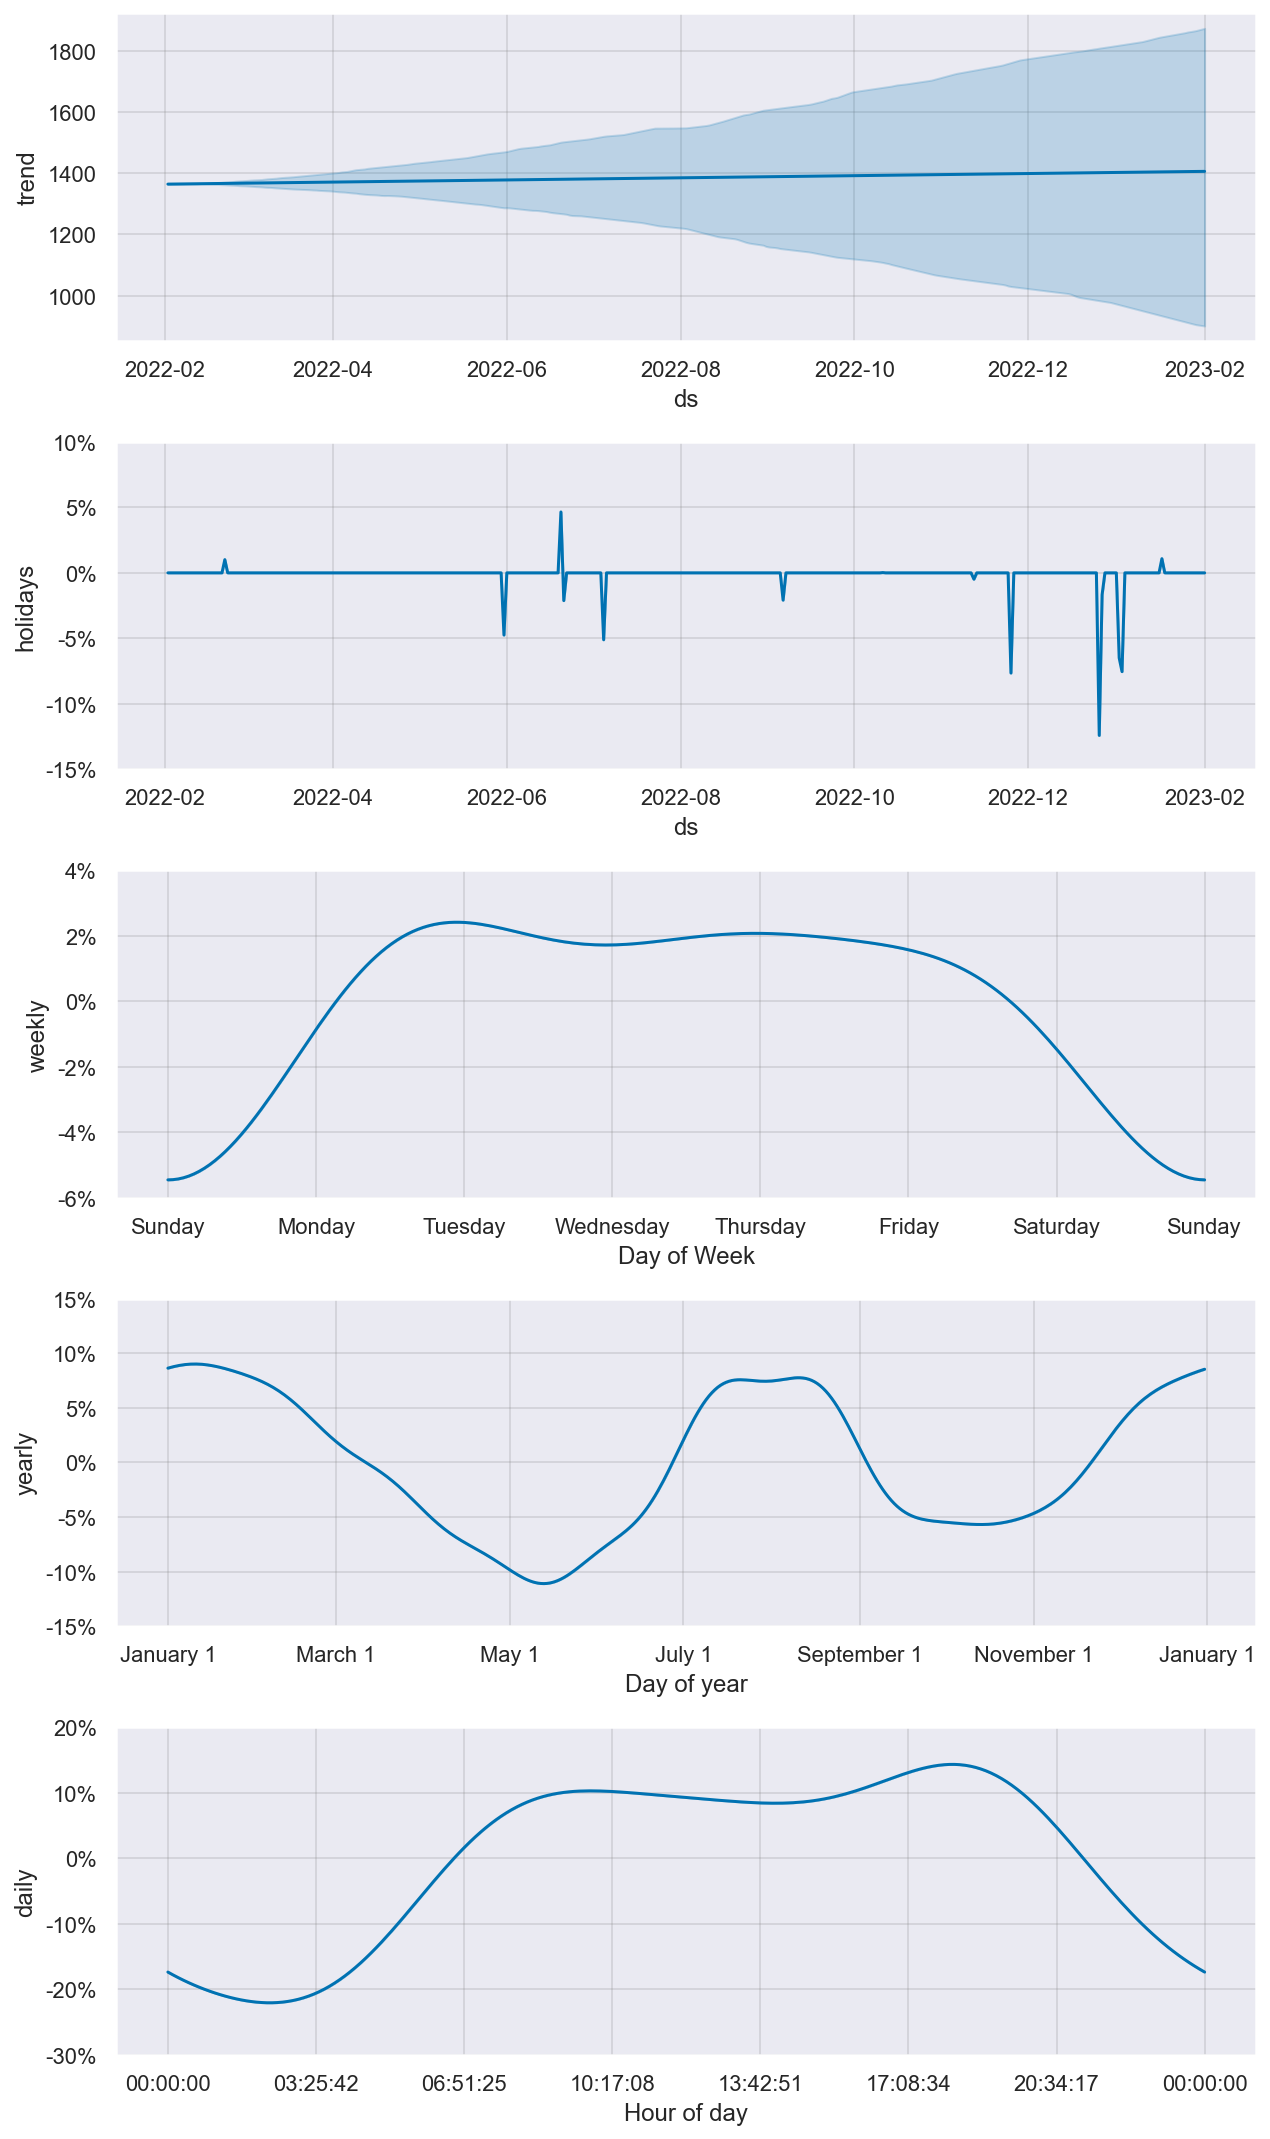

In [17]:
fig2 = model.plot_components(forecast_pd)

In [18]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-02-01 23:00:00,1364.410590,1147.306353,1485.481436,1364.410590,1364.410590,0.0,0.0,0.0,0.0,...,0.017194,0.017194,0.017194,0.075676,0.075676,0.075676,0.0,0.0,0.0,1317.003047
1,2022-02-02 23:00:00,1364.524930,1158.272033,1488.079124,1364.524930,1364.524930,0.0,0.0,0.0,0.0,...,0.020749,0.020749,0.020749,0.074519,0.074519,0.074519,0.0,0.0,0.0,1320.384860
2,2022-02-03 23:00:00,1364.639270,1130.790660,1495.410646,1364.639270,1364.639270,0.0,0.0,0.0,0.0,...,0.016152,0.016152,0.016152,0.073294,0.073294,0.073294,0.0,0.0,0.0,1312.550828
3,2022-02-04 23:00:00,1364.753610,1112.042273,1447.868457,1364.753610,1364.753610,0.0,0.0,0.0,0.0,...,-0.012446,-0.012446,-0.012446,0.071994,0.071994,0.071994,0.0,0.0,0.0,1271.858105
4,2022-02-05 23:00:00,1364.867950,1050.667124,1383.864905,1364.867950,1364.867950,0.0,0.0,0.0,0.0,...,-0.054430,-0.054430,-0.054430,0.070613,0.070613,0.070613,0.0,0.0,0.0,1212.777612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-01-27 23:00:00,1405.572907,864.403930,1755.671181,907.933452,1863.827581,0.0,0.0,0.0,0.0,...,-0.012446,-0.012446,-0.012446,0.080907,0.080907,0.080907,0.0,0.0,0.0,1322.425794
361,2023-01-28 23:00:00,1405.687247,775.394663,1711.611134,905.666811,1865.601350,0.0,0.0,0.0,0.0,...,-0.054430,-0.054430,-0.054430,0.079998,0.079998,0.079998,0.0,0.0,0.0,1262.239972
362,2023-01-29 23:00:00,1405.801586,835.506995,1785.749796,904.246699,1868.045671,0.0,0.0,0.0,0.0,...,-0.011363,-0.011363,-0.011363,0.079053,0.079053,0.079053,0.0,0.0,0.0,1321.558768
363,2023-01-30 23:00:00,1405.915926,872.582556,1857.667637,902.835093,1870.461345,0.0,0.0,0.0,0.0,...,0.024145,0.024145,0.024145,0.078069,0.078069,0.078069,0.0,0.0,0.0,1370.202006


In [16]:
forecast_pd.to_csv('me_forecast.csv', index=False)